<a href="https://colab.research.google.com/github/gopinathak-geek/Image-classification-with-pytorch/blob/main/Titanic_spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [167]:
training_df = pd.read_csv('train.csv')
testing_df = pd.read_csv('test.csv')

In [168]:
def clean_training_data(training_data):
    df = training_data.copy()
    df = df.dropna()
    numericals = []
    for i in range(len(df.dtypes)):
        coltype = df.dtypes[i]
        if (coltype != object): 
            numericals.append(df.iloc[:, i])
    df = pd.DataFrame (numericals).T
    return df

def clean_testing_data(testing_data):
    df = testing_data.copy()
    cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    for col in cols:
        df[col].fillna(df[col].median(), inplace=True)
    numericals = []
    for i in range(len(df.dtypes)):
        coltype = df.dtypes[i]
        if (coltype != object): 
            numericals.append(df.iloc[:, i])
    df = pd.DataFrame (numericals).T
    return df

In [169]:
training_data_df = clean_training_data(training_df)
testing_data_df = clean_testing_data(testing_df)
test_ids = testing_df['PassengerId']

training_data_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0
...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0.0
8689,18.0,0.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0.0


In [170]:
X = training_data_df.drop(['Transported'], axis=1)
y = training_data_df['Transported']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=69)

In [172]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_k_test = scaler.transform(testing_data_df)

In [173]:
EPOCHS = 500
BATCH_SIZE = 1000
LEARNING_RATE = 0.001

In [174]:
X_train

array([[-1.9841733 , -0.34938003, -0.28080437, -0.30412253, -0.27767595,
        -0.26928524],
       [-0.8869437 , -0.34938003, -0.28080437, -0.30412253, -0.27767595,
        -0.26928524],
       [ 2.47332195, -0.34938003, -0.28080437, -0.30412253, -0.27767595,
        -0.26928524],
       ...,
       [ 0.2102859 , -0.34938003,  2.16651367,  0.33793811,  0.52421425,
        -0.26755473],
       [-0.40690575, -0.34938003, -0.28080437, -0.30412253,  0.37318561,
        -0.2000648 ],
       [ 0.27886275, -0.34938003,  2.32505887, -0.30412253,  3.4108392 ,
        -0.26928524]])

In [175]:
torch.FloatTensor(X_train)

tensor([[-1.9842, -0.3494, -0.2808, -0.3041, -0.2777, -0.2693],
        [-0.8869, -0.3494, -0.2808, -0.3041, -0.2777, -0.2693],
        [ 2.4733, -0.3494, -0.2808, -0.3041, -0.2777, -0.2693],
        ...,
        [ 0.2103, -0.3494,  2.1665,  0.3379,  0.5242, -0.2676],
        [-0.4069, -0.3494, -0.2808, -0.3041,  0.3732, -0.2001],
        [ 0.2789, -0.3494,  2.3251, -0.3041,  3.4108, -0.2693]])

In [176]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

In [177]:
train_data[0]

(tensor([-1.9842, -0.3494, -0.2808, -0.3041, -0.2777, -0.2693]), tensor(1.))

In [178]:
test_data = TrainData(torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy()))

In [179]:

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

k_test_data = TestData(torch.FloatTensor(X_k_test))

In [180]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
k_test_loader = DataLoader(dataset=k_test_data, batch_size=1)

In [181]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(6, 12) 
        self.layer_2 = nn.Linear(12, 24)
        self.layer_3 = nn.Linear(24, 48)
        self.layer_4 = nn.Linear(48, 12)
        self.layer_5 = nn.Linear(12, 6)
        self.layer_out = nn.Linear(6, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(12)
        self.batchnorm2 = nn.BatchNorm1d(24)
        self.batchnorm3 = nn.BatchNorm1d(48)
        self.batchnorm4 = nn.BatchNorm1d(12)
        self.batchnorm5 = nn.BatchNorm1d(6)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [182]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [183]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=6, out_features=12, bias=True)
  (layer_2): Linear(in_features=12, out_features=24, bias=True)
  (layer_3): Linear(in_features=24, out_features=48, bias=True)
  (layer_4): Linear(in_features=48, out_features=12, bias=True)
  (layer_5): Linear(in_features=12, out_features=6, bias=True)
  (layer_out): Linear(in_features=6, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [184]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [185]:
train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

for e in range(1, EPOCHS+1):
    model.train()
    epoch_loss_train = 0
    epoch_acc_train = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss_train += loss.item()
        epoch_acc_train += acc.item()
    with torch.no_grad():
      model.eval()
      epoch_loss_val = 0
      epoch_acc_val = 0

      for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        epoch_loss_val += loss.item()
        epoch_acc_val += acc.item()

        
    train_loss_history.append(epoch_loss_train/len(train_loader))
    train_acc_history.append(epoch_acc_train/len(train_loader))

    val_loss_history.append(epoch_loss_val/len(test_loader))
    val_acc_history.append(epoch_acc_val/len(test_loader))
    print(f'Epoch {e+0:03}: | Training Loss: {epoch_loss_train/len(train_loader):.5f} | validation Loss: {epoch_loss_val/len(test_loader):.5f} | Training Acc: {epoch_acc_train/len(train_loader):.3f} | validation Acc: {epoch_acc_val/len(test_loader):.3f}')

Epoch 001: | Training Loss: 0.69265 | validation Loss: 0.70212 | Training Acc: 56.500 | validation Acc: 50.303
Epoch 002: | Training Loss: 0.65615 | validation Loss: 0.69595 | Training Acc: 61.333 | validation Acc: 50.303
Epoch 003: | Training Loss: 0.63084 | validation Loss: 0.68335 | Training Acc: 65.167 | validation Acc: 51.513
Epoch 004: | Training Loss: 0.61520 | validation Loss: 0.66246 | Training Acc: 68.000 | validation Acc: 65.053
Epoch 005: | Training Loss: 0.60043 | validation Loss: 0.63378 | Training Acc: 71.000 | validation Acc: 68.986
Epoch 006: | Training Loss: 0.58892 | validation Loss: 0.60410 | Training Acc: 72.500 | validation Acc: 72.466
Epoch 007: | Training Loss: 0.57731 | validation Loss: 0.57998 | Training Acc: 73.500 | validation Acc: 74.054
Epoch 008: | Training Loss: 0.56406 | validation Loss: 0.56216 | Training Acc: 76.000 | validation Acc: 75.265
Epoch 009: | Training Loss: 0.55129 | validation Loss: 0.54922 | Training Acc: 76.833 | validation Acc: 75.643
E

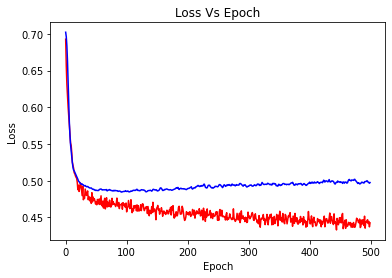

In [194]:
import matplotlib.pyplot as plt

plt.title('Loss Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_history, '-r')
plt.plot(val_loss_history, '-b')

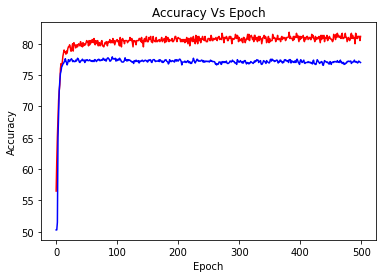

In [187]:
plt.title('Accuracy Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc_history, '-r')
plt.plot(val_acc_history, '-b')

In [188]:
from sklearn.metrics import confusion_matrix
def get_accuracy_sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total = sum(sum(cm))
    accuracy = (cm[0,0]+ cm[1,1])/total
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    return accuracy, sensitivity, specificity

#accuracy, sensitivity, specificity = get_accuracy_sensitivity_specificity(y_test, y_pred_list)
#print(f'Accuracy = {accuracy}\nSensitivity = {sensitivity}\nSpecificity = {specificity}')

In [189]:
k_y_pred_list = []
model.eval()
with torch.no_grad():
    for k_X_batch in k_test_loader:
        k_X_batch = k_X_batch.to(device)
        k_y_test_pred = model(k_X_batch)
        k_y_test_pred = torch.sigmoid(k_y_test_pred)
        k_y_pred_tag = torch.round(k_y_test_pred)
        k_y_pred_list.append(k_y_pred_tag.cpu().numpy())

k_y_pred_list = [a.squeeze().tolist() for a in k_y_pred_list]

In [190]:
def say_true_false(prediction):
    test_data_predection = []
    for i in (prediction):
        if (i > 0.5):
            test_data_predection.append(True)
        else:
            test_data_predection.append(False)
    return test_data_predection

In [191]:
a = say_true_false(k_y_pred_list)

In [192]:
df = pd.DataFrame({"PassengerId":test_ids, "Transported":a })
df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [193]:
df.to_csv("submission.csv", index=False)